In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    StandardScaler,
)
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import warnings

warnings.filterwarnings("ignore")
print("Setup complete")

Setup complete


<IPython.core.display.Javascript object>

#  Stroke Prediction

The task for this work is to analyse the Stroke Prediction dataset. The task is to create a machine learning model, which could predict if the patient is likely to get a stroke - being able to determine which patients have high stroke risk will allow your doctors to advise them and their families on how to act in case of an emergency.  I will apply what I have learned about Machine Learning to complete this task.

**Objectives for this work:**
* Practice working with CSV files.
* Practice performing EDA.
* Practice applying statistical inference procedures.
* Practice using various types of machine learning models.
* Practice building ensembles of machine learning models.
* Practice deploying machine learning models.
* Practice visualizing data with Matplotlib & Seaborn.
* Practice reading data, performing queries, and filtering data.

**Requirements**
* Perform exploratory data analysis:<br>
    - create statistical summaries and charts,
    - test for anomalies, 
    - check for correlations and other relations between variables, and other EDA elements.
* Perform statistical inference:<br>
    - define the target population,
    - form multiple statistical hypotheses and constructing confidence intervals, 
    - set the significance levels, 
    - conduct z or t-tests for these hypotheses.
* Apply various machine learning models to predict the "stroke" column using all other features:<br>
    - include hyperparameter tuning, 
    - include model ensembling,
    - include the analysis of model selection, and other methods.
    
* Deploy the machine learning model (in a container (on your computer or on a server), do a serverless deployment on the cloud, or on the browser as a web app)


* Download the given dataset and check the overall information: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

**About Data:** 
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient.

* **id** - Unique Identifier
* **gender** - "Male", "Female" or "Other"
* **age** - Age of the Patient
* **hypertension** - 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* **heart_disease** - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* **ever_married** - "No" or "Yes"
* **work_type** - "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* **Residence_type** - "Rural" or "Urban"
* **avg_glucose_level** - average glucose level in blood
* **bmi** - body mass index
* **smoking_status** - "formerly smoked", "never smoked", "smokes" or "Unknown" (the information is unavailable for this patient)
* **stroke** - 1 if the patient had a stroke or 0 if not

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<IPython.core.display.Javascript object>

* Dataframe consists of 5110 entries and 12 features(columns):

In [4]:
df.shape

(5110, 12)

<IPython.core.display.Javascript object>

* There are no duplicated entries in dataframe:

In [5]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

* Dataset contains 5 not numeric features('gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status') and 6 numeric features ('age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke'):

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<IPython.core.display.Javascript object>

* From overall information we see interesting information to check in 'age', 'avg_glucose_level' and 'bmi' columns. It also shows, that our data is not normally distributed and will be needed to transform for future modeling:

In [7]:
round(df.describe(exclude="object"), 2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


<IPython.core.display.Javascript object>

* There are missing values in column 'bmi' 3.93% of total information. We will come to this in the modeling part, but now I will impute missing values using KNNImputer:

In [8]:
round(df.isna().sum() * 100 / len(df), 2)

id                   0.00
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
dtype: float64

<IPython.core.display.Javascript object>

In [9]:
bmi_imputer = KNNImputer(n_neighbors=5)
df["bmi"] = bmi_imputer.fit_transform(df[["bmi"]])
df["bmi"].isna().sum()

0

<IPython.core.display.Javascript object>

To detect outliers we plot certain numeric features:'age', 'avg_glucose_level', 'bmi'. From plot bellow we see the age is very widle spread, there are outliers in glucose levels and bmi:

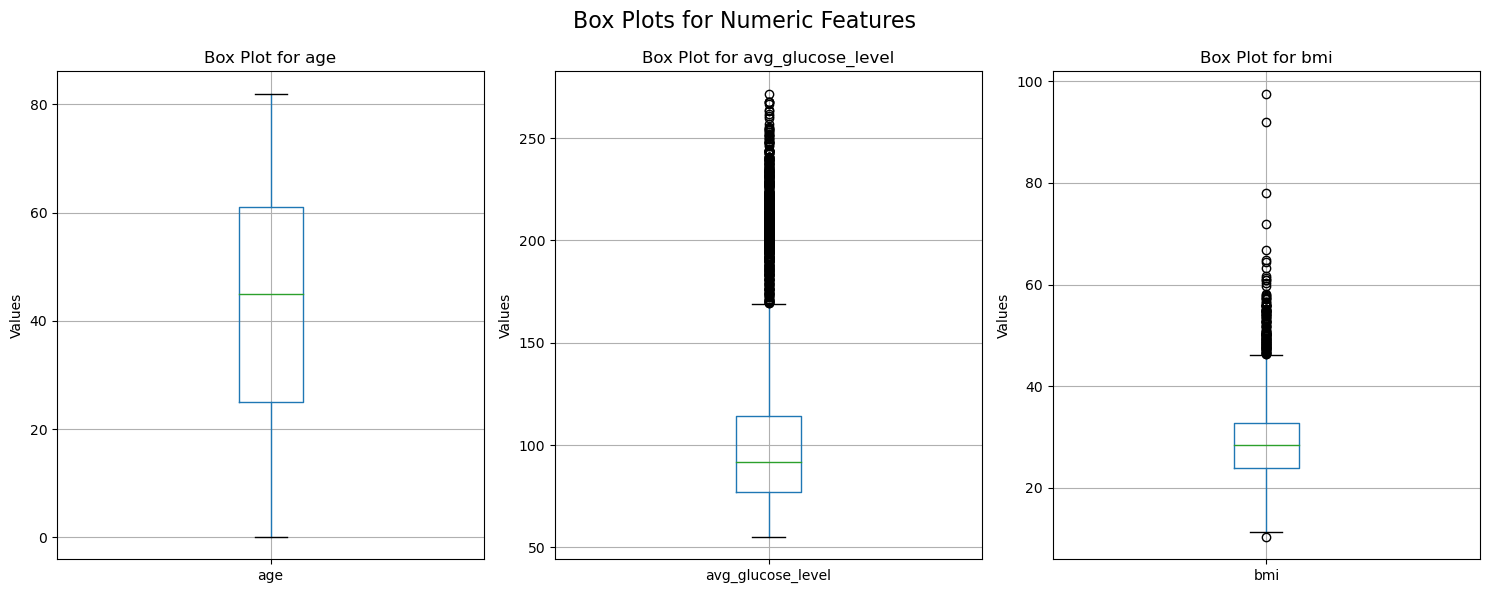

<IPython.core.display.Javascript object>

In [10]:
features = ["age", "avg_glucose_level", "bmi"]
fig, axes = plt.subplots(1, len(features), figsize=(15, 6))
for i, feature in enumerate(features):
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f"Box Plot for {feature}")
    axes[i].set_ylabel("Values")
fig.suptitle("Box Plots for Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


<IPython.core.display.Javascript object>

* Checking relations between features with respect to 'stroke' feature. It shows that correaltions are very weak if we consider that -1 is a strong negative correlation, 0 means no correlation and +1 is strong correlation:

stroke               1.000000
age                  0.245239
heart_disease        0.134905
avg_glucose_level    0.131991
hypertension         0.127891
bmi                  0.038912
id                   0.006430
Name: stroke, dtype: float64


<AxesSubplot: >

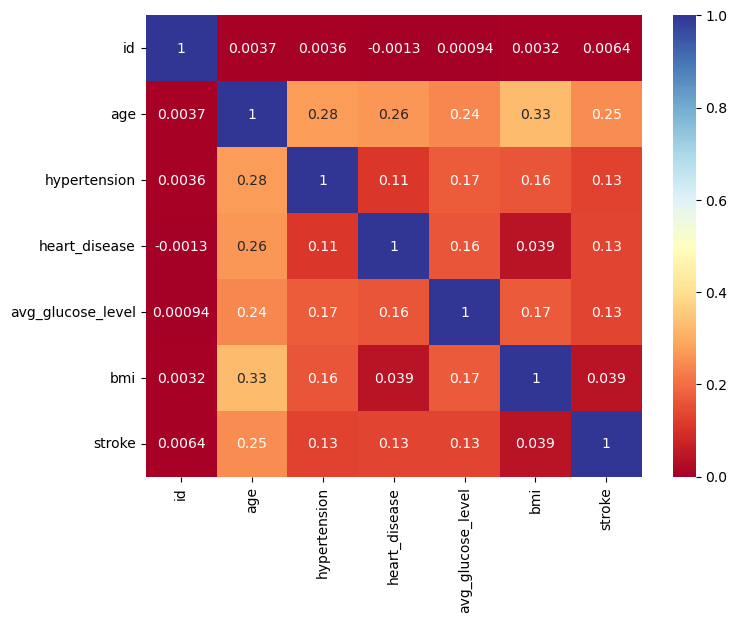

<IPython.core.display.Javascript object>

In [43]:
correlations = df.corr(numeric_only=True)["stroke"].sort_values(ascending=False)
print(correlations)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2g", cmap="RdYlBu", cbar=True)

### What is the age scale in dataset?


The age range in dataset:  0.08 - 82.0 years


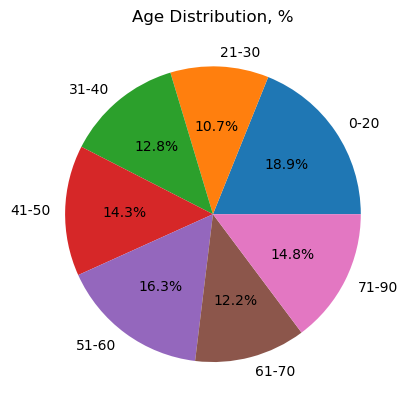

<IPython.core.display.Javascript object>

In [13]:
age_bins = [0, 20, 30, 40, 50, 60, 70, 90]
age_labels = ["0-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-90"]
print("The age range in dataset: ", df.age.min(), "-", df.age.max(), "years")
age_hist, _ = np.histogram(df["age"], bins=age_bins)

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(age_hist, labels=age_labels, autopct="%1.1f%%")
plt.title("Age Distribution, %")
plt.show()

In [14]:
stroke_yes = df[df["stroke"] == 1]
stroke_no = df[df["stroke"] == 0]

<IPython.core.display.Javascript object>

### What is age distribution in relation with stroke feature?

* In relation to stroke possibility, the biggest risk are people age from 71 to 90. But in general risk rises from 51 (19.3% were diagnosed positively):

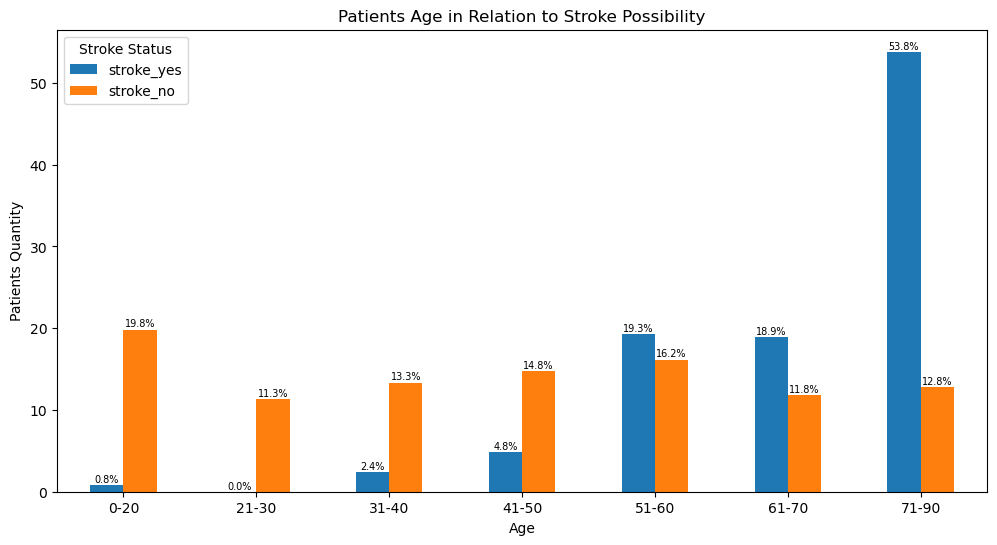

<IPython.core.display.Javascript object>

In [15]:
stroke_yes["age_bins"] = pd.cut(
    stroke_yes["age"], bins=age_bins, labels=age_labels, right=False
)
stroke_no["age_bins"] = pd.cut(
    stroke_no["age"], bins=age_bins, labels=age_labels, right=False
)

age_by_stroke_counts = stroke_yes["age_bins"].value_counts().sort_index()
age_by_no_stroke_counts = stroke_no["age_bins"].value_counts().sort_index()
age_counts_df = pd.DataFrame(
    {
        "stroke_yes": age_by_stroke_counts,
        "stroke_no": age_by_no_stroke_counts,
    }
)
age_counts_df["stroke_yes"] = round(
    age_counts_df["stroke_yes"] * 100 / age_counts_df["stroke_yes"].sum(), 2
)
age_counts_df["stroke_no"] = round(
    age_counts_df["stroke_no"] * 100 / age_counts_df["stroke_no"].sum(), 2
)

# Create and display the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
age_counts_df.plot(kind="bar", ax=ax)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
ax.set_title("Patients Age in Relation to Stroke Possibility")
ax.set_xlabel("Age")
plt.xticks(rotation=0)
ax.set_ylabel("Patients Quantity")
plt.legend(title="Stroke Status", loc="upper left")
plt.show()

### Which gender is more likely to have a stroke?

* The plot shows that women are more likely to have a stroke (~57%):

Female patients in total:  2994
Male patients in total:  2115


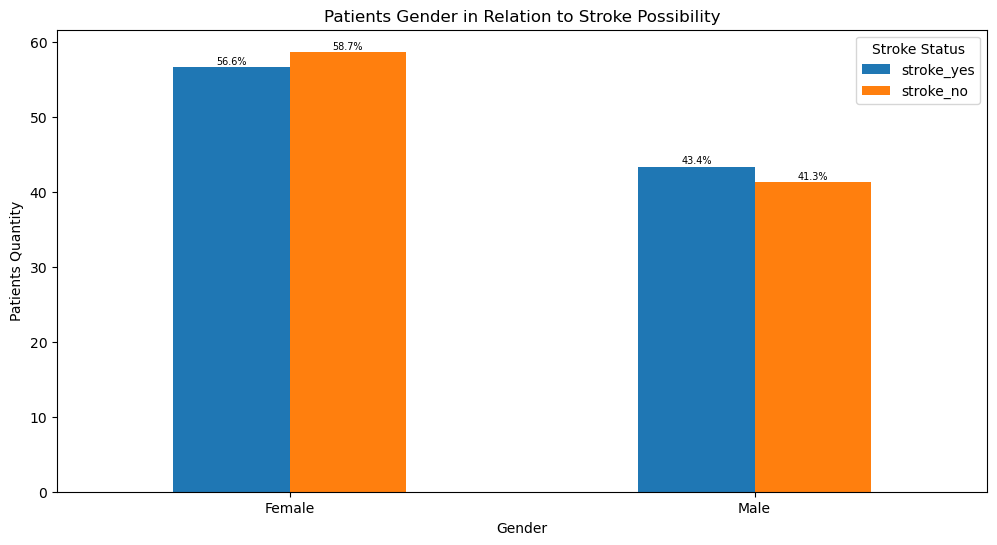

<IPython.core.display.Javascript object>

In [16]:
print(
    "Female patients in total: ",
    df["gender"].value_counts()[0],
)
print(
    "Male patients in total: ",
    df["gender"].value_counts()[1],
)
gender_by_stroke_counts = stroke_yes["gender"].value_counts()
gender_by_no_stroke_counts = stroke_no["gender"].value_counts()
gender_counts_df = pd.DataFrame(
    {
        "stroke_yes": gender_by_stroke_counts,
        "stroke_no": gender_by_no_stroke_counts,
    }
)
gender_counts_df.sort_index(inplace=True)
gender_counts_df["stroke_yes"] = round(
    gender_counts_df["stroke_yes"] * 100 / gender_counts_df["stroke_yes"].sum(), 2
)
gender_counts_df["stroke_no"] = round(
    gender_counts_df["stroke_no"] * 100 / gender_counts_df["stroke_no"].sum(), 2
)
fig, ax = plt.subplots(figsize=(12, 6))
gender_counts_df.iloc[:2, :].plot(kind="bar", ax=ax)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
ax.set_title("Patients Gender in Relation to Stroke Possibility")
ax.set_xlabel("Gender")
plt.xticks(rotation=0)
ax.set_ylabel("Patients Quantity")
plt.legend(title="Stroke Status", loc="upper right")
plt.show()


### What marital status tends to have stroke more:


* We see that ever_married people tend to have stroke far more often then single people:

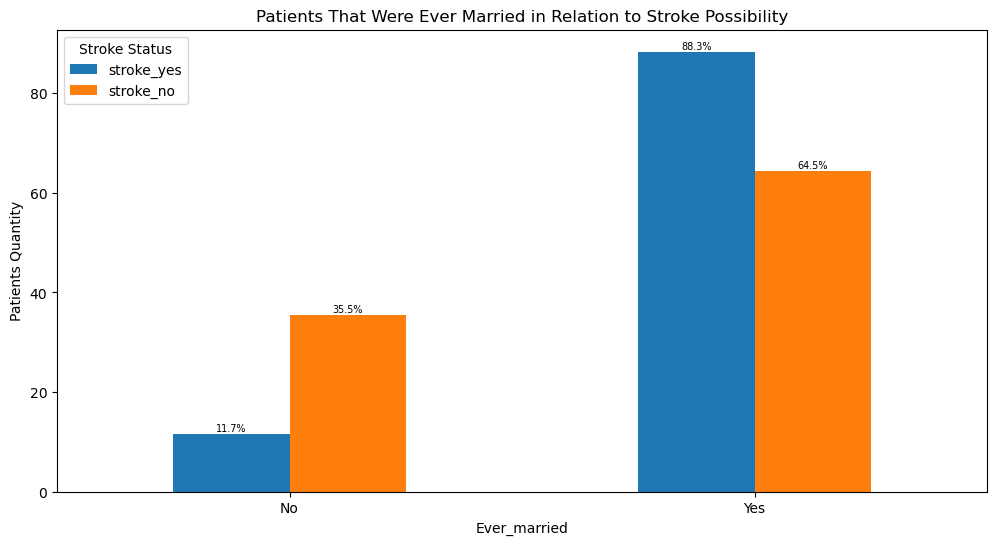

<IPython.core.display.Javascript object>

In [17]:
married_by_stroke_counts = stroke_yes["ever_married"].value_counts()
married_by_no_stroke_counts = stroke_no["ever_married"].value_counts()
married_counts_df = pd.DataFrame(
    {
        "stroke_yes": married_by_stroke_counts,
        "stroke_no": married_by_no_stroke_counts,
    }
)
married_counts_df.sort_index(inplace=True)
married_counts_df["stroke_yes"] = round(
    married_counts_df["stroke_yes"] * 100 / married_counts_df["stroke_yes"].sum(), 2
)
married_counts_df["stroke_no"] = round(
    married_counts_df["stroke_no"] * 100 / married_counts_df["stroke_no"].sum(), 2
)
fig, ax = plt.subplots(figsize=(12, 6))
married_counts_df.plot(kind="bar", ax=ax)
for i in ax.patches:
    ax.annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
ax.set_title("Patients That Were Ever Married in Relation to Stroke Possibility")
ax.set_xlabel("Ever_married")
plt.xticks(rotation=0)
ax.set_ylabel("Patients Quantity")
plt.legend(title="Stroke Status", loc="upper left")
plt.show()


* Providing various plots to see tendencies in patients group that had stroke:

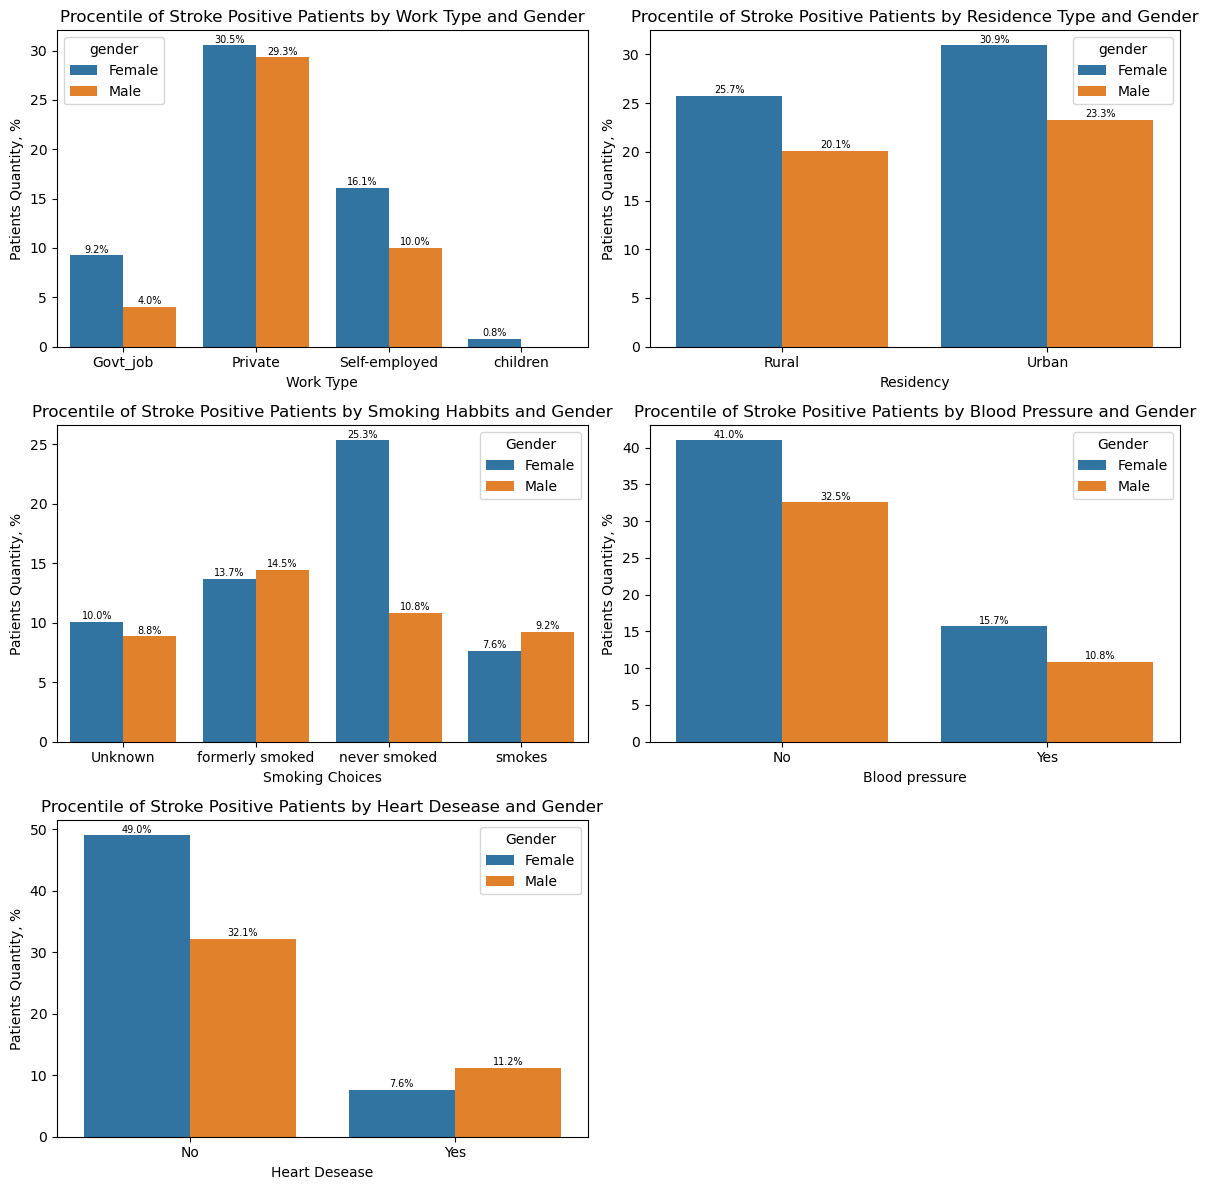

<IPython.core.display.Javascript object>

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Work Type plot
procentile = (
    stroke_yes.groupby(["work_type", "gender"])["gender"].count()
    * 100
    / stroke_yes.groupby(["work_type", "gender"])["gender"].value_counts().sum()
)
procentile_df = procentile.reset_index(name="Procentile")
sns.barplot(
    data=procentile_df, x="work_type", y="Procentile", hue="gender", ax=axes[0, 0]
)
for i in axes[0, 0].patches:
    axes[0, 0].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
axes[0, 0].set_title("Procentile of Stroke Positive Patients by Work Type and Gender")
axes[0, 0].set_xlabel("Work Type")
axes[0, 0].set_ylabel("Patients Quantity, %")

# Residency Type plot
procentile = (
    stroke_yes.groupby(["Residence_type", "gender"])["gender"].count()
    * 100
    / stroke_yes.groupby(["Residence_type", "gender"])["gender"].value_counts().sum()
)
procentile_df = procentile.reset_index(name="Procentile")
sns.barplot(
    data=procentile_df, x="Residence_type", y="Procentile", hue="gender", ax=axes[0, 1]
)
for i in axes[0, 1].patches:
    axes[0, 1].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
axes[0, 1].set_title(
    "Procentile of Stroke Positive Patients by Residence Type and Gender"
)
axes[0, 1].set_xlabel("Residency")
axes[0, 1].set_ylabel("Patients Quantity, %")

# Smoking Habits plot
procentile = (
    stroke_yes.groupby(["smoking_status", "gender"])["gender"].count()
    * 100
    / stroke_yes.groupby(["smoking_status", "gender"])["gender"].value_counts().sum()
)
procentile_df = procentile.reset_index(name="Procentile")
sns.barplot(
    data=procentile_df, x="smoking_status", y="Procentile", hue="gender", ax=axes[1, 0]
)
for i in axes[1, 0].patches:
    axes[1, 0].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
axes[1, 0].set_title(
    "Procentile of Stroke Positive Patients by Smoking Habbits and Gender"
)
axes[1, 0].set_xlabel("Smoking Choices")
axes[1, 0].set_ylabel("Patients Quantity, %")
axes[1, 0].legend(title="Gender")

# Blood pressure plot
procentile = (
    stroke_yes.groupby(["hypertension", "gender"])["gender"].count()
    * 100
    / stroke_yes.groupby(["hypertension", "gender"])["gender"].value_counts().sum()
)
procentile_df = procentile.reset_index(name="Procentile")
sns.barplot(
    data=procentile_df, x="hypertension", y="Procentile", hue="gender", ax=axes[1, 1]
)
for i in axes[1, 1].patches:
    axes[1, 1].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
axes[1, 1].set_title(
    "Procentile of Stroke Positive Patients by Blood Pressure and Gender"
)
axes[1, 1].set_xlabel("Blood pressure")
axes[1, 1].set_xticks([0, 1], ["No", "Yes"])
axes[1, 1].set_ylabel("Patients Quantity, %")
axes[1, 1].legend(title="Gender")

# Heart desease plot
procentile = (
    stroke_yes.groupby(["heart_disease", "gender"])["gender"].count()
    * 100
    / stroke_yes.groupby(["heart_disease", "gender"])["gender"].value_counts().sum()
)
procentile_df = procentile.reset_index(name="Procentile")
sns.barplot(
    data=procentile_df, x="heart_disease", y="Procentile", hue="gender", ax=axes[2, 0]
)
for i in axes[2, 0].patches:
    axes[2, 0].annotate(
        f"{i.get_height():.1f}%",
        (i.get_x() + i.get_width() / 2, i.get_height()),
        textcoords="offset points",
        xytext=(0, 2),
        size=7,
        ha="center",
    )
axes[2, 0].set_title(
    "Procentile of Stroke Positive Patients by Heart Desease and Gender"
)
axes[2, 0].set_xlabel("Heart Desease")
axes[2, 0].set_xticks([0, 1], ["No", "Yes"])
axes[2, 0].set_ylabel("Patients Quantity, %")
axes[2, 0].legend(title="Gender")

axes[2, 1].axis("off")
plt.tight_layout()
plt.show()

Conclusion:<br>
* Most stroke sufferers work in the private sector and a higher proportion are women (30.5%);<br>
* Most patients live in urban areas (female group 30.9%);<br>
* The female group of stroke patients has never smoked (25.3%), the second group of patients admits to having smoked in the past, but almost 18% of both men and women are not known to smoke;<br>
* Both genders admit to having had no blood pressure problems;<br>
* Both stroke patiens genders admit to having no heart disease.

### Glucose levels impact on stroke patients:

**Hypothesis**: glucose level has impact on patients having stroke;<br>
**Alternative**: There is no meaningful difference in glucose level effect to get stroke 

In [19]:
def data_normality_check(data, column):
    statistic, p_value = shapiro(data[column])
    print(f"Test Statistic: {statistic}")
    print(f"P-value: {p_value}")
    alpha = 0.05
    if p_value > alpha:
        print(
            "The data follows a normal distribution (fail to reject the null hypothesis)."
        )
    else:
        print(
            "The data does not follow a normal distribution (reject the null hypothesis)."
        )

<IPython.core.display.Javascript object>

In [20]:
def plot_hist(dataframe, column_name, message):
    fig, ax = plt.subplots(1, figsize=(10, 3))
    sns.histplot(dataframe[column_name], kde=True)
    ax.set_title("Histogram - {} for {} Patients".format(column_name, message))
    ax.set_xlabel(column_name)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [21]:
def statistical_significance(data1, data2, alpha=0.05, alternative="two-sided"):
    statistic, p_value = mannwhitneyu(data1, data2, alternative=alternative)
    print("P-value:", p_value)
    if p_value < alpha:
        print("There is a statistically significant difference between the groups.")
    else:
        print("There is no statistically significant difference between the groups.")


<IPython.core.display.Javascript object>

In [22]:
def mean_difference(data1, data2):
    column_name = data1.name
    mean_difference = round(data1.mean() - data2.mean(), 2)
    print(f"The difference between groups in {column_name} mean: {mean_difference}")

<IPython.core.display.Javascript object>

In [23]:
def confidence_interval(dataframe, column_name, confidence_level=0.95):
    data = dataframe[column_name]

    mean = data.mean()
    std = data.std()
    n = len(data)

    standard_error = std / np.sqrt(n)
    margin_of_error = standard_error * 1.96

    lower_bound = round((mean - margin_of_error), 2)
    upper_bound = round((mean + margin_of_error), 2)

    print(
        "{}% Confidence Interval for {} mean: [{:.2f}, {:.2f}] mg/dL".format(
            confidence_level * 100, column_name, lower_bound, upper_bound
        )
    )

<IPython.core.display.Javascript object>

Let's check if data is normally distributed in our dataframe. For that I use Shapiro-Wilk Test and histogram to visualise results:
the null hypothesis is that the data follows a normal distribution
If p-value is lower than alpha means data is not normally distributed.
* In both the "Stroke positive" and the "Stroke negative" groups, the Shapiro-Wilk test results p-values obtained are very close to zero, meaning that we reject the idea that the data in both groups is normally distributed.

In [24]:
data_normality_check(df, "avg_glucose_level")

Test Statistic: 0.8058695197105408
P-value: 0.0
The data does not follow a normal distribution (reject the null hypothesis).


<IPython.core.display.Javascript object>

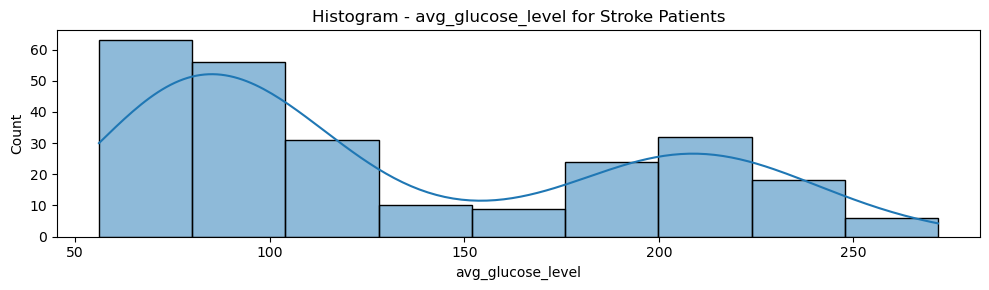

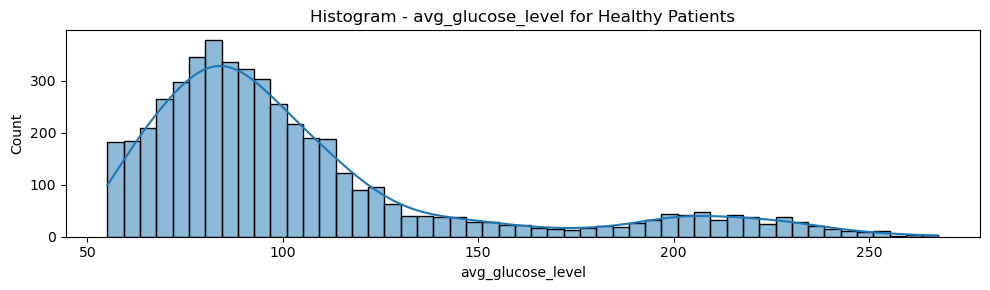

<IPython.core.display.Javascript object>

In [25]:
plot_hist(stroke_yes, "avg_glucose_level", "Stroke")
plot_hist(stroke_no, "avg_glucose_level", "Healthy")

In [26]:
statistical_significance(
    stroke_yes["avg_glucose_level"], stroke_no["avg_glucose_level"]
)

P-value: 3.6403672710893236e-09
There is a statistically significant difference between the groups.


<IPython.core.display.Javascript object>

In [27]:
mean_difference(
    stroke_yes["avg_glucose_level"],
    stroke_no["avg_glucose_level"],
)

The difference between groups in avg_glucose_level mean: 27.75


<IPython.core.display.Javascript object>

In [28]:
stroke_yes = df[df["stroke"] == 1]
stroke_no = df[df["stroke"] == 0]
print("Stroke patients:")
confidence_interval(stroke_yes, "avg_glucose_level")
print("Healthy patients:")
confidence_interval(stroke_no, "avg_glucose_level")

Stroke patients:
95.0% Confidence Interval for avg_glucose_level mean: [124.85, 140.24] mg/dL
Healthy patients:
95.0% Confidence Interval for avg_glucose_level mean: [103.56, 106.03] mg/dL


<IPython.core.display.Javascript object>

### Data Processing

* There is 1 gender "Other" for only one patient, so for modeling convenience I will remove it:

In [29]:
other = df[df["gender"] == "Other"].index
df.drop(other, inplace=True)

<IPython.core.display.Javascript object>

* Column 'id' has no value to us, therefore I delete it. * To fill missing values in 'bmi' column I use KNNImputer (uses k-Nearest Neighbors):

* For model evaluation I will use F1 score. A good F1 score means that you have low false positives and low false negatives. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0

In [30]:
X = df.drop(["stroke", "id"], axis=1)
y = df["stroke"]

<IPython.core.display.Javascript object>

In [31]:
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

<IPython.core.display.Javascript object>

In [32]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked


<IPython.core.display.Javascript object>

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [34]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
y_train.value_counts(), y_test.value_counts()

(stroke
 0    3888
 1     199
 Name: count, dtype: int64,
 stroke
 0    972
 1     50
 Name: count, dtype: int64)

<IPython.core.display.Javascript object>

In [36]:
num_preparing = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", StandardScaler())]
)
cat_preparing = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))]
)
preparing = ColumnTransformer(
    [("num", num_preparing, num_features), ("cat", cat_preparing, cat_features)],
)

<IPython.core.display.Javascript object>

* Making initial pipeline:

In [37]:
pipeline = Pipeline(
    [
        ("preparing", preparing),
        (
            "classifier",
            LogisticRegression(class_weight="balanced"),
        ),
    ]
)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print("Logistic Regression: \n", report)

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.99      0.74      0.84       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022



<IPython.core.display.Javascript object>

In [38]:
param_grid = [
    {
        "classifier": [
            RandomForestClassifier(class_weight="balanced", random_state=42)
        ],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__n_estimators": [100, 150, 200, 300, 500, 1000],
        "classifier__max_depth": [None, 1, 3, 5, 8, 10, 15],
        "classifier__max_features": ["log2", "sqrt", "auto"],
        "classifier__min_samples_split": [5, 10],
        "classifier__min_samples_leaf": [5, 10],
    },
    {
        "classifier": [KNeighborsClassifier(n_jobs=-1)],
        "classifier__n_neighbors": [1, 3, 5, 7],
        "classifier__weights": ["uniform", "distance"],
    },
    {
        "classifier": [LogisticRegression(class_weight="balanced")],
        "classifier__solver": ["lbfgs", "liblinear", "sag", "saga"],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10],
    },
    {
        "classifier": [SVC(class_weight="balanced")],
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf", "poly"],
        "classifier__gamma": ["scale", "auto"],
    },
    {
        "classifier": [XGBClassifier(random_state=42)],
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7, 10],
        "classifier__gamma": [0, 0.1, 0.2, 0.3],
        "classifier__scale_pos_weight": [1, round(len(y_train) / sum(y_train), 2)],
    },
    {
        "classifier": [
            DecisionTreeClassifier(class_weight="balanced", random_state=42)
        ],
        "classifier__max_depth": [5, 10, 15, None],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__min_samples_leaf": [1, 2, 4, 0.1, 0.2],
        "classifier__max_features": ["auto", "sqrt", "log2", None],
    },
]

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    return_train_score=True,
)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
best_models = []
for i, params in enumerate(grid.cv_results_["params"]):
    model_name = params["classifier"].__class__.__name__
    best_models.append((model_name, params, grid.cv_results_["mean_test_score"][i]))
best_models.sort(key=lambda x: x[2], reverse=True)

seen_models = set()
for model_name, best_params, mean_f1_score in best_models:
    if model_name not in seen_models:
        seen_models.add(model_name)
        print(f"Best parameters for {model_name}: {best_params}")
        print(f"Best Mean F1 Score: {mean_f1_score}")
        print("=" * 50)

Best parameters for RandomForestClassifier: {'classifier': RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=10,
                       min_samples_split=5, n_estimators=150, random_state=42), 'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Best Mean F1 Score: 0.259862296603832
Best parameters for XGBClassifier: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat

<IPython.core.display.Javascript object>

In [39]:
classifiers = [
    (
        "Logistic Regression",
        LogisticRegression(class_weight="balanced", C=0.001, solver="lbfgs"),
    ),
    (
        "Random Forest",
        RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            max_depth=None,
            max_features="log2",
            min_samples_leaf=10,
            min_samples_split=5,
            criterion="entropy",
            n_estimators=100,
            n_jobs=-1,
        ),
    ),
    (
        "XGBClassifier",
        XGBClassifier(
            gamma=0.1,
            learning_rate=0.1,
            max_depth=5,
            n_estimators=100,
            scale_pos_weight=21.86,
        ),
    ),
    (
        "Dtree",
        DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42,
            criterion="entropy",
            max_depth=5,
            max_features=None,
            min_samples_leaf=0.1,
        ),
    ),
    ("K-Neighbors", KNeighborsClassifier(n_jobs=-1, n_neighbors=1, weights="uniform")),
    ("SVC", SVC(class_weight="balanced", C=1, gamma="auto", kernel="rbf")),
]

for name, classifier in classifiers:
    pipeline = Pipeline(
        [
            ("preparing", preparing),
            ("select", SelectKBest(k=6, score_func=f_regression)),
            ("classifier", classifier),
        ]
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(name + ":\n", report)
    print("=" * 50)

Logistic Regression:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.82      1022

Random Forest:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91       972
           1       0.18      0.60      0.28        50

    accuracy                           0.85      1022
   macro avg       0.58      0.73      0.60      1022
weighted avg       0.94      0.85      0.88      1022

XGBClassifier:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.16      0.62      0.25        50

    accuracy                           0.82      1022
   macro avg       0.57      0.72      0.57      1022
weighted avg       0

<IPython.core.display.Javascript object>

* Based on individual performance and F1 score I esemble the final model:

In [48]:
classifiers = [
    (
        "Dtree",
        DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42,
            criterion="entropy",
            max_depth=5,
            max_features=None,
            min_samples_leaf=0.1,
        ),
    ),
    (
        "Random Forest",
        RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            max_depth=None,
            max_features="log2",
            min_samples_leaf=10,
            min_samples_split=5,
            criterion="entropy",
            n_estimators=100,
            n_jobs=-1,
        ),
    ),
    (
        "XGBC",
        XGBClassifier(
            gamma=0.1,
            learning_rate=0.1,
            max_depth=5,
            n_estimators=100,
            scale_pos_weight=21.86,
        ),
    ),
    ("K-Neighbors", KNeighborsClassifier(n_jobs=-1, n_neighbors=1, weights="uniform")),
]

pipeline_list = [
    (
        name,
        Pipeline(
            [
                ("preparing", preparing),
                ("select", SelectKBest(k=8, score_func=f_regression)),
                ("classifier", classifier),
            ]
        ),
    )
    for name, classifier in classifiers
]

classifier = VotingClassifier(estimators=pipeline_list, voting="hard")

classifier.fit(X_train, y_train)
selected_features_indices = pipeline.named_steps["select"].get_support(indices=True)
selected_feature_names = [
    [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ][i]
    for i in selected_features_indices
]
print(f"Features selected by {name}: {selected_feature_names}")
y_pred = classifier.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, y_pred)
ensemble_precision = precision_score(y_test, y_pred)
ensemble_f1 = f1_score(y_test, y_pred)

print("Ensemble Model Accuracy:", ensemble_accuracy)
print("Ensemble Model Precision:", ensemble_precision)
print("Ensemble Model F1 Score:", ensemble_f1)

Features selected by SVC: ['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Ensemble Model Accuracy: 0.8776908023483366
Ensemble Model Precision: 0.2222222222222222
Ensemble Model F1 Score: 0.32432432432432434


<IPython.core.display.Javascript object>

* Saving the trained model:

In [49]:
import joblib

<IPython.core.display.Javascript object>

In [50]:
joblib.dump(classifier, "essembled_model.joblib")

['essembled_model.joblib']

<IPython.core.display.Javascript object>

### Conclusions:
* This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status etc.;
* Dataset has 5110 entries and 12 features;
* The age range in dataset:  0.08 - 82.0 years;
* In relation to stroke possibility, the biggest risk are people age from 71 to 90. But in general risk rises from 51 (19.3% were diagnosed positively):
* In total there are 2994 females and 2115. Data shows that women are more likely to have a stroke (~57%);
* Ever_married people tend to have stroke far more often then single people;
* Most stroke sufferers work in the private sector and a higher proportion are women (30.5%);
* Most patients live in urban areas (female group 30.9%);
* The female group of stroke patients has never smoked (25.3%), the second group of patients admits to having smoked in the past, but almost 18% of both men and women are not known to smoke;
* Both genders admit to having had no blood pressure problems;
* Both genders admit to having no heart disease.

Hypothesis: glucose level has impact on patients having stroke;
Alternative: There is no meaningful difference in glucose level effect to get stroke
In both the "Stroke positive" and the "Stroke negative" groups, the Shapiro-Wilk test shows that data in 'average_glucose_level' is not normally distributed
Stroke patients:
95.0% Confidence Interval for avg_glucose_level mean: [124.85, 140.24] mg/dL
Healthy patients:
95.0% Confidence Interval for avg_glucose_level mean: [103.56, 106.03] mg/dL

Processing dataset for stroke prediction revealed that data is highly imbalanced therefore the used ensembled model showed overall accuracy of 88%, and f1 score 32% accuracy.

### Improvements:
Further study of machine learning and pipelining is needed, as well as improving the representation of correlation between attributes (categorical and numerical),
study of model deployment and the development of additional applications to retrieve customer data.